# Human Activity Recognition
## Time Series Classification using LSTM

Human activity recognition (HAR) is the problem of classifying sequences of accelerometer data recorded by smart phones into known well-defined movements. It has numerous applications in healthcare as an assistive technology when ensemble with other technologies like IoT. 

We are going to use HAR data set from the UCI machine learning repository. You can find the data set on canvas and read details about the data set here: https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones. The dataset was collected from 30 subjects, performing different activities with a smartphone to their waists. The data was recorded with the help of sensors (accelerometer and Gyroscope) in that smartphone. The goal is to classify sequences of sensor data into the human activities such as walking, walking upstairs, walking downstairs, sitting, standing and laying. Therefore, it is a time series multi-class classification problem. 

For more information, you may read the following paper: https://www.ijrte.org/wp-content/uploads/papers/v8i1/A1385058119.pdf. 

# Part 0: Background Reading
Before starting this assignment, you should familiarize yourself with PyTorch. You should read [their tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) and preferably follow along with a Colab notebook. You should only have to fully read the sections:
* "What is PyTorch?"
* *Optional* "Autograd: Automatic Differentiation"
* "Neural Networks"
* "Training a Classifier"

This should take about an hour (according to the name of the tutorial). Once you are done with that, you should be more ready to tackle this assignment! You will probably also want to look at the [documentation](https://pytorch.org/docs/stable/index.html) to understand what parameters they are specifying in the tutorial.

First we import all of the modules we will use in this assignment.

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.optim as optim

Then we define some constants that will be used throughout the program.

In [3]:
INPUT_DIM     = 9             # The number of input dimensions in LSTM which is the number of signals.
HIDDEN_DIM    = 128           # The number of hiddern dimensions in LSTM. 
OUTPUT_DIM    = 6             # The number of output classes. 
N_LAYERS      = 3             # The number of layers in LSTM. 
NUM_EPOCHS    = 10            # The number of times we loop over the whole dataset during training
BATCH_SIZE    = 32            # The size of input data took for one iteration of an epoch
LEARNING_RATE = 1e-3          # The speed of convergence

## Part 1: Data Loading

There are six different activites: walking, walking_upstairs, walking_downstairs, sitting, standing, and laying. 

In [4]:
LABELS = [
    'WALKING',
    'WALKING_UPSTAIRS',
    'WALKING_DOWNSTAIRS',
    'SITTING',
    'STANDING',
    'LAYING',
]

For each activity, there are total 9 preprocessed signals with T = 128 time points. 

In [5]:
# Raw data signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
    ]

The code for data loading is based on https://github.com/MadhavShashi/Human-Activity-Recognition-Using-Smartphones-Sensor-DataSet/blob/master/3.%20Applying%20LSTM.ipynb. 

In [6]:
# function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            pd.read_csv(filename, delim_whitespace=True, header=None).to_numpy()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return torch.tensor(np.transpose(signals_data, (1, 2, 0)), dtype=torch.float)

In [7]:
def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. 
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = pd.read_csv(filename, delim_whitespace=True, header=None)[0].to_numpy()-1

    return torch.tensor(y, dtype=torch.int64)

In [8]:
def load_data():
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')
    return X_train, X_test, y_train, y_test

In [9]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [10]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

torch.Size([7352, 128, 9])
torch.Size([7352])
torch.Size([2947, 128, 9])
torch.Size([2947])


Now we are going to build train/test data loaders. Most of the time we use the `train_loader` instead of the `trainset`. The reason being the loader gives us batches of examples from the entire `trainset`. Looping over the `train_loader` returns a subset of the examples on each iteration. 


In [11]:
train_loader = DataLoader(
    TensorDataset(X_train, Y_train),
    batch_size = BATCH_SIZE,
    shuffle = True,
    drop_last=True
)

In [12]:
test_loader = DataLoader(
    TensorDataset(X_test, Y_test),
    batch_size = BATCH_SIZE,
    shuffle = True,
    drop_last=True
)

Check the size of tensors in the dataloader. 

In [13]:
x, y = next(iter(train_loader))
print(x.shape)
print(y.shape)

torch.Size([32, 128, 9])
torch.Size([32])


## Part 2: Build LSTM model

Now we are going to write the PyTorch code to build the neural network model that has the following operations:
- Build a LSTM layer with the given number of layers
- The final hidden state has a shape [N_LAYERS, BATCH_SIZE, HIDDEN_DIM]. Reshape it to [BATCH_SIZE, N_LAYERS x HIDDEN_DIM].
- Build a fully connected linear layer to the final hidden state

In [16]:
class LSTM(nn.Module):
    
    def __init__(self,input_dim,hidden_dim,output_dim,n_layers):
        
        super(LSTM,self).__init__()

        ####################################################################

        # TODO Initialize layers
        #self.input_dim=input_dim
        #self.hidden_dim=hidden_dim
        #self.output_dim=output_dim
        #self.n_layers=n_layers
        self.lstm=nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)
        self.linear=nn.Linear(n_layers*hidden_dim,output_dim)



        ####################################################################
        
    def forward(self,inputs):

        ####################################################################
        
        # TODO Complete forward pass
        output,states=self.lstm(inputs)
        hidden_state=torch.flatten(torch.transpose(states[0],0,1),start_dim=1)
        out=self.linear(hidden_state)

        



        ####################################################################

        return out

In [17]:
lstm_model = LSTM(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS)

## Part 3: Training and Testing

In the cell below, we define the critical helper functions to train and see the results of the neural networks. Fill in the gap. 

In [18]:
def train(model, train_loader, test_loader,
          num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE,
          compute_accs=False):
    """
    This function trains the given network on the training data for the given number of epochs.
    If compute_accs is true, evaluates the train and test accuracy of the network at the end of
    each epoch.

    Args:
        model: The neural network to train
        train_loader, test_loader: The pytorch dataset loaders for the trainst and testset
        num_epochs: The number of times to loop over the batches in train_loader
        learning_rate: The learning rate for the optimizer
        compute_accs: A bool flag for whether or not this function should compute the train and test
                      accuracies at the end of each epoch. This feature is useful for visualizing
                      how the model is learning, but slows down training time.
    Returns:
        The train and test accuracies if compute_accs is True, None otherwise
    """
    # First initialize the criterion (loss function) and the optimizer
    # (algorithm like gradient descent). Here we use a common loss function for multi-class
    # classification called the Cross Entropy Loss and the popular Adam algorithm.
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_accs = []
    test_accs = []

    for epoch in range(1, num_epochs + 1):
        batch_num = 1
        for inputs, targets in train_loader:   # Loop over each batch in train_loader

            # If you are using a GPU, speed up computation by moving values to the GPU
            if torch.cuda.is_available():
                model = model.cuda()
                inputs = inputs.cuda()
                targets = targets.cuda()

            ####################################################################

            # TODO Implement following 5 steps 

            # 1) Reset gradient for next computation
            # 2) Forward pass: compute the output class given inputs
            # 3) Compute loss: difference between the pred and true 
            # 4) Backward pass: compute the weight
            # 5) Optimizer: update the weights of hidden nodes
            optimizer.zero_grad()
            outputs=lstm_model(inputs)
            loss=criterion(outputs,targets)
            loss.backward()
            optimizer.step()

            #################################################################### 

            if batch_num % 100 == 0:  # Print every 100 batches                              
                print(f'Epoch [{epoch}/{num_epochs}], Step [{batch_num}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}')
            
            batch_num += 1

        if compute_accs:
            train_acc = accuracy(model, train_loader) 
            test_acc = accuracy(model, test_loader) 
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            print(f'Epoch [{epoch}/{num_epochs}], Train Accuracy {100 * train_acc:.2f}%, Test Accuracy {100 * test_acc:.2f}%')

    if compute_accs:
        return train_accs, test_accs
    else:
        return None

def accuracy(model, data_loader):
    """
    For a given data_loader, evaluate the model on the dataset and compute its classification
    accuracy.

    Args:
        model: The neural network to train
        data_loader: A dataset loader for some dataset.
    Returns:
        The classificiation accuracy of the model on this dataset.
    """
    correct = 0
    total = 0
    for inputs, targets in data_loader:

        # If you are using a GPU, speed up computation by moving values to the GPU
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            targets = targets.cuda()

        outputs = model(inputs)                          # Make predictions
        _, predicted = torch.max(outputs.data, 1)        # Choose class with highest scores
        total += targets.size(0)                         # Increment the total count
        correct += (predicted == targets).sum().item()   # Increment the correct count

    return correct / total

Now we are all ready! Let's start training the model!

In [19]:
train_history, test_history = train(lstm_model, train_loader, test_loader,
                                    num_epochs=NUM_EPOCHS, 
                                    learning_rate=LEARNING_RATE, 
                                    compute_accs=True)

Epoch [1/10], Step [100/229], Loss: 1.0440
Epoch [1/10], Step [200/229], Loss: 1.0241
Epoch [1/10], Train Accuracy 66.53%, Test Accuracy 64.33%
Epoch [2/10], Step [100/229], Loss: 1.6259
Epoch [2/10], Step [200/229], Loss: 0.7518
Epoch [2/10], Train Accuracy 64.27%, Test Accuracy 59.71%
Epoch [3/10], Step [100/229], Loss: 0.7877
Epoch [3/10], Step [200/229], Loss: 0.6628
Epoch [3/10], Train Accuracy 67.78%, Test Accuracy 64.40%
Epoch [4/10], Step [100/229], Loss: 0.5274
Epoch [4/10], Step [200/229], Loss: 0.4478
Epoch [4/10], Train Accuracy 77.29%, Test Accuracy 72.32%
Epoch [5/10], Step [100/229], Loss: 0.6240
Epoch [5/10], Step [200/229], Loss: 0.3862
Epoch [5/10], Train Accuracy 73.40%, Test Accuracy 69.57%
Epoch [6/10], Step [100/229], Loss: 0.6900
Epoch [6/10], Step [200/229], Loss: 0.6024
Epoch [6/10], Train Accuracy 77.85%, Test Accuracy 69.84%
Epoch [7/10], Step [100/229], Loss: 0.9072
Epoch [7/10], Step [200/229], Loss: 0.6318
Epoch [7/10], Train Accuracy 72.78%, Test Accuracy

Let's plot some examples. 

In [20]:
import matplotlib.pyplot as plt

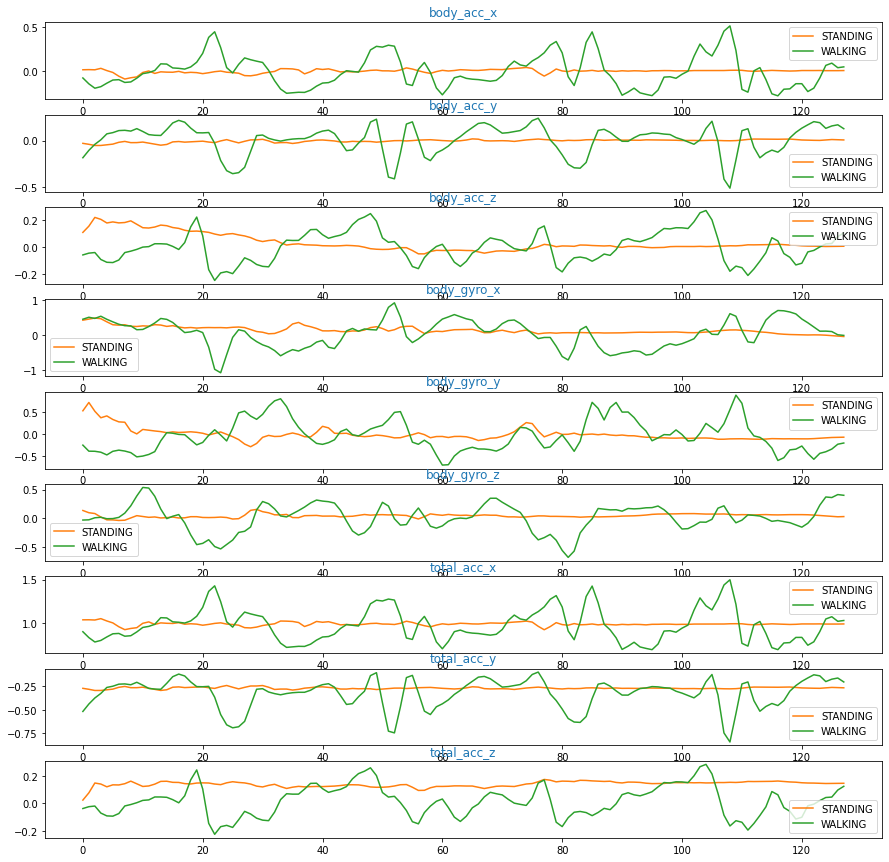

In [21]:
figure, axis = plt.subplots(9, 1, figsize=(15, 15))
index1 = 0
index2 = 100
for i in range(INPUT_DIM):
  axis[i].set_title(SIGNALS[i], color='C0')
  axis[i].plot(X_test[index1, :,i].numpy(), 'C1', label=LABELS[Y_test[index1].numpy()])
  axis[i].plot(X_test[index2, :,i].numpy(), 'C2', label=LABELS[Y_test[index2].numpy()])
  axis[i].legend()

In [22]:
if torch.cuda.is_available():
  output1 = lstm_model(X_test[index1, ][None, :, :].cuda())
  output2 = lstm_model(X_test[index2, ][None, :, :].cuda())
else :
  output1 = lstm_model(X_test[index1, ][None, :, :])
  output2 = lstm_model(X_test[index2, ][None, :, :])
_, prediction1 = torch.max(output1.data, 1) 
print("The target activity is ", LABELS[Y_test[index1]], "and the predicted activity is ", LABELS[prediction1])
_, prediction2 = torch.max(output2.data, 1) 
print("The target activity is ", LABELS[Y_test[index2]], "and the predicted activity is ", LABELS[prediction2])

The target activity is  STANDING and the predicted activity is  STANDING
The target activity is  WALKING and the predicted activity is  WALKING


# Before you submit
Make sure you have run all the cells and the graph appears in your notebook. For grading, we need to see the desired output in your notebook.
